

This notebook accompanies the [workshop paper](http://jiahao.github.io/parallel-prefix/) by Jiahao Chen and Alan Edelman entitled "Parallel Prefix Polymorphism Permits Parallelization, Presentation & Proof" and will appear in the proceedings of the [First Workshop for High Performance Technical Computing in Dynamic Languages](http://jiahao.github.io/hptcdl-sc14/), held in conjunction with [SC14: The International Conference on High Performance Computing, Networking, Storage and Analysis](http://sc14.supercomputing.org/).



In [3]:
using Compose, Gadfly, Interact

# `reduce()`

Reduction applies a binary operator to a vector repeatedly to return a scalar. Thus + becomes sum, and * becomes prod.

It is considered a basic parallel computing primitive.



In [4]:
reduce(+, 1:8), sum(1:8)  # triangular numbers

(36, 36)

In [5]:
reduce(*, 1:8), prod(1:8) # factorials

(40320, 40320)

In [6]:
boring(a,b)=a
@show reduce(boring, 1:8)
boring2(a,b)=b
@show reduce(boring2, 1:8)

reduce(boring, 1:8) = 1
reduce(boring2, 1:8) = 8


8

You can also use reduce to compute Fibonacci numbers using their recurrences.

$$\begin{pmatrix} f_2 \\f_1 \end{pmatrix} = \begin{pmatrix} f_1 + f_0 \\ f_1 \end{pmatrix}
= \begin{pmatrix} 1 & 1 \\ 1 & 0 \end{pmatrix} \begin{pmatrix} f_1 \\ f_0 \end{pmatrix} $$

$$\begin{pmatrix} f_{n+1} \\ f_n \end{pmatrix} = \dots
= \begin{pmatrix} 1 & 1 \\ 1 & 0 \end{pmatrix}^n \begin{pmatrix} f_1 \\ f_0 \end{pmatrix} $$

From this, you can show that

$$\begin{pmatrix} 1 & 1 \\ 1 & 0 \end{pmatrix}^n  = \begin{pmatrix} f_{n+1} & f_n \\ f_n & f_{n-1} \end{pmatrix} $$

(this applies reduce to the same argument over and over again -- there are of course other ways)

In [7]:
M=[1 1; 1 0]
reduce(*,fill(M,3))

2×2 Array{Int64,2}:
 3  2
 2  1

In [8]:
fib(j)=reduce(*, fill(M,j))
fib.([4,7])


2-element Array{Array{Int64,2},1}:
 [5 3; 3 2]   
 [21 13; 13 8]

You can solve recurrences of any complexity using `reduce`. For example, `reduce` can compute a Hadamard matrix from its definition in terms of its submatrices:

$$H_2 = \begin{pmatrix} H_1 & H_1 \\ H_1 & -H_1 \end{pmatrix} = \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} \otimes H_1$$

and so on.

(Note: this is just using reduce to compute a matrix power.
One can think of alternative ways for sure.)

In [9]:
# [A B]
# If A is m x n
# If B is p x q
# then kron(A,B) is mp x nq and has all the elements of A times all of the elements of B

In [10]:
A=[1 2;3 4]
B=[10 100; 1 -10]
⊗(A,B)=kron(A,B)

M=[ 1 1;1 -1]
H=⊗(⊗(⊗(M,M),M),M)
H'H 

16×16 Array{Int64,2}:
 16   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0  16   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0  16   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0  16   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0  16   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0  16   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0  16   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0  16   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0  16   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0  16   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0  16   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0  16   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0  16   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0  16   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0  16   0
  0   0   0   0   

In [11]:
Hadamard(n)=reduce(⊗, fill(M,n))
H=Hadamard(3)

8×8 Array{Int64,2}:
 1   1   1   1   1   1   1   1
 1  -1   1  -1   1  -1   1  -1
 1   1  -1  -1   1   1  -1  -1
 1  -1  -1   1   1  -1  -1   1
 1   1   1   1  -1  -1  -1  -1
 1  -1   1  -1  -1   1  -1   1
 1   1  -1  -1  -1  -1   1   1
 1  -1  -1   1  -1   1   1  -1

In [12]:
H'H

8×8 Array{Int64,2}:
 8  0  0  0  0  0  0  0
 0  8  0  0  0  0  0  0
 0  0  8  0  0  0  0  0
 0  0  0  8  0  0  0  0
 0  0  0  0  8  0  0  0
 0  0  0  0  0  8  0  0
 0  0  0  0  0  0  8  0
 0  0  0  0  0  0  0  8

In [13]:
H*H' #This is a legitimate Hadamard matrix

8×8 Array{Int64,2}:
 8  0  0  0  0  0  0  0
 0  8  0  0  0  0  0  0
 0  0  8  0  0  0  0  0
 0  0  0  8  0  0  0  0
 0  0  0  0  8  0  0  0
 0  0  0  0  0  8  0  0
 0  0  0  0  0  0  8  0
 0  0  0  0  0  0  0  8

In [14]:
using StatsBase

In [15]:
rolldice() = rand(1:6)+rand(1:6)
rolls(n)=fit(Histogram,[rolldice() for i=1:n ],2:12,closed=:left)

rolls (generic function with 1 method)

In [16]:
reduce(merge,[rolls(100) for i=1:10])

StatsBase.Histogram{Int64,1,Tuple{UnitRange{Int64}}}
edges:
  2:12
weights: [20, 66, 95, 108, 126, 164, 150, 107, 81, 56]
closed: left
isdensity: false

In [17]:
#Reduction of matrix multiplications
M=[rand(-3:3,2,2) for i=1:4]

display(M[4]*M[3]*M[2]*M[1])
display(reduce((A,B)->B*A, M)) #backward multiply
display(reduce(*, M))          #forward multiply

2×2 Array{Int64,2}:
 -42  21
  -6   3

2×2 Array{Int64,2}:
 -42  21
  -6   3

2×2 Array{Int64,2}:
 36  -102
  0     0

In the following example we apply `reduce()` to  function composition:

In [18]:
h=reduce( (f,g) -> (x->f(g(x))), [sin cos tan])
[h(π) sin(cos(tan(π)))]

1×2 Array{Float64,2}:
 0.841471  0.841471

In [19]:
cumsum(1:8)  # It is useful to know that cumsum is a linear operator
# You can use power method! Below is the underlying matrix
A=tril(ones(Int,8,8)) 

8×8 Array{Int64,2}:
 1  0  0  0  0  0  0  0
 1  1  0  0  0  0  0  0
 1  1  1  0  0  0  0  0
 1  1  1  1  0  0  0  0
 1  1  1  1  1  0  0  0
 1  1  1  1  1  1  0  0
 1  1  1  1  1  1  1  0
 1  1  1  1  1  1  1  1

In [20]:
[A*(1:8),cumsum(1:8)]

2-element Array{Array{Int64,1},1}:
 [1, 3, 6, 10, 15, 21, 28, 36]
 [1, 3, 6, 10, 15, 21, 28, 36]

# `prefix`

Having discussed `reduce`, we are now ready for the idea behind prefix sum.
Prefix or scan is long considered an important parallel
primitive as well.

Suppose you wanted to compute the partial sums of a vector, i.e. given
`y[1:n]`, we want to overwrite the vector `y` with the vector of partial sums

```julia
new_y[1] = y[1]
new_y[2] = y[1] + y[2]
new_y[3] = y[1] + y[2] + y[3]
...
```

At first blush, it seems impossible to parallelize this, since

```julia
new_y[1] = y[1]
new_y[2] = new_y[1] + y[2]
new_y[3] = new_y[2] + y[3]
...
```

which appears to be an intrinsically serial process.

In [21]:
function prefix_serial!(y, +)
    @inbounds for i=2:length(y)
        y[i] = y[i-1] + y[i]
    end
    y
end

prefix_serial! (generic function with 1 method)

In [22]:
prefix_serial!([rand(1:5,2,2) for i=1:4],*)

4-element Array{Array{Int64,2},1}:
 [3 1; 5 3]        
 [10 16; 18 28]    
 [78 68; 138 120]  
 [458 526; 810 930]

However, it turns out that because addition (`+`) is associative, we can regroup the _order_ of how these sums are carried out. (This of course extends to other associative operations such as multiplication.) Another ordering of 8 associative operations is provided by `prefix8!`:

In [23]:
# Eight only for pedagogy
function prefix8!(y, ⋅)
    length(y)==8 || error("length 8 only")
    for i in [2,4,6,8]; y[i] = y[i-1] ⋅ y[i]; end
    for i in [  4,  8]; y[i] = y[i-2] ⋅ y[i]; end
    for i in [      8]; y[i] = y[i-4] ⋅ y[i]; end
    for i in [    6  ]; y[i] = y[i-2] ⋅ y[i]; end
    for i in [ 3,5,7 ]; y[i] = y[i-1] ⋅ y[i]; end
    y
end

# Generalization to any n
function prefix!(y, ⋅)
    l=length(y)
    k=ceil(Int, log2(l))
    @inbounds for j=1:k, i=2^j:2^j:min(l, 2^k)              #"reduce"
        y[i] = y[i-2^(j-1)] ⋅ y[i]
    end
    @inbounds for j=(k-1):-1:1, i=3*2^(j-1):2^j:min(l, 2^k) #"broadcast"
        y[i] = y[i-2^(j-1)] ⋅ y[i]
    end
    y
end

prefix! (generic function with 1 method)

In [24]:
prefix!([1:12;],*)

12-element Array{Int64,1}:
         1
         2
         6
        24
       120
       720
      5040
     40320
    362880
   3628800
  39916800
 479001600

# Polymorphism for visualization

We can visualize the operations with a little bit of trickery. In Julia, arrays are simply types that expose the array protocol. In particular, they need to implement  methods for the generic functions `length`, `getindex` and `setindex!`. The last two are used in indexing operations, since statements

    y = A[1]
    A[3] = y
    
get desugared to

    y = getindex(A, 1)
    setindex!(A, y, 3)
    
respectively.

We can trace through the iterable by introduce a dummy array type, `DummyArray`, which stores no useful information but records every access to `getindex` and `setindex!`.

Specifically:

- `length(A::DummyArray)` returns an integer that is stored internally in the `A.length` field
- `getindex(A::DummyArray, i)` records read access to the index `i` in the `A.read` field and always retuns `nothing`.
- `setindex!(A::DummyArray, x, i)` records write access to the index `i`. The `A.history` field is appended with a new tuple consisting of the current `A.read` field and the index `i`. 

The way `DummyArray` works, it assumes an association between a single `setindex!` call and and all the preceding `getindex` calls since the previous `setindex!` call, which is sufficient for the purposes of tracing through prefix calls.

In [25]:
import Base: getindex, setindex!, length

isdefined(:DummyArray) || type DummyArray
    length :: Int
    read :: Vector
    history :: Vector{Any}
    DummyArray(length, read=[], history=[])=new(length, read, history)
end

length(A::DummyArray)=A.length

function getindex(A::DummyArray, i)
    push!(A.read, i)
    nothing
end

function setindex!(A::DummyArray, x, i)
    push!(A.history, (A.read, [i]))
    A.read = []
end

setindex! (generic function with 188 methods)

In [26]:
M = DummyArray(4)

DummyArray(4, Any[], Any[])

In [37]:
import Base.+
+(a::Void, b::Void)=a

+ (generic function with 279 methods)

In [42]:
@manipulate for i=1:100
    M = DummyArray(4)
    M[i]
    M
end

Interact.Options{:SelectionSlider,Any}(49: "input-15" = 50 Any , "i", 50, "50", 50, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(68, "68"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(89, "89"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(39, "39"),Pair{Any,Any}(46, "46"),Pair{Any,Any}(85, "85"),Pair{Any,Any}(25, "25"),Pair{Any,Any}(55, "55"),Pair{Any,Any}(42, "42")…)), Any[], Any[], true, "horizontal")

DummyArray(4, Any[50], Any[])

We also need a dummy associative operator to pass to the prefix call.

In [43]:
A=prefix8!(DummyArray(8),+)

DummyArray(8, Any[], Any[(Any[1, 2], [2]), (Any[3, 4], [4]), (Any[5, 6], [6]), (Any[7, 8], [8]), (Any[2, 4], [4]), (Any[6, 8], [8]), (Any[4, 8], [8]), (Any[4, 6], [6]), (Any[2, 3], [3]), (Any[4, 5], [5]), (Any[6, 7], [7])])

In [44]:
A.history

11-element Array{Any,1}:
 (Any[1, 2], [2])
 (Any[3, 4], [4])
 (Any[5, 6], [6])
 (Any[7, 8], [8])
 (Any[2, 4], [4])
 (Any[6, 8], [8])
 (Any[4, 8], [8])
 (Any[4, 6], [6])
 (Any[2, 3], [3])
 (Any[4, 5], [5])
 (Any[6, 7], [7])

Now let's visualize this! Each entry in `A.history` is rendered by a gate object:

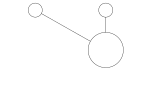

In [45]:
type gate
    ins :: Vector
    outs:: Vector
end

import Gadfly.render

function render(G::gate, x₁, y₁, y₀; rᵢ=0.1, rₒ=0.25)
    ipoints = [(i, y₀+rᵢ) for i in G.ins]
    opoints = [(i, y₀+0.5) for i in G.outs]
    igates  = [circle(i..., rᵢ) for i in ipoints]
    ogates  = [circle(i..., rₒ) for i in opoints]
    lines = [line([i, j]) for i in ipoints, j in opoints]
    compose(context(units=UnitBox(0.5,0,x₁,y₁+1)),
    compose(context(), stroke(colorant"black"), fill(colorant"white"),
            igates..., ogates...),
    compose(context(), linewidth(0.3mm), stroke(colorant"black"),
            lines...))
end

A=gate([1,2],[2])
render(A,2,0,0)

Now we render the whole algorithm. We have to scan through the trace twice; the first time merely calculates the maximum depth that needs to be drawn and the second time actually generates the objects.

In [47]:
function render(A::DummyArray)
    #Scan to find maximum depth
    olast = depth = 0
    for y in A.history
        (any(y[1] .≤ olast)) && (depth += 1)
        olast = maximum(y[2])
    end
    maxdepth = depth
    
    olast = depth = 0
    C = []
    for y in A.history
        (any(y[1] .≤ olast)) && (depth += 1)
        push!(C, render(gate(y...), A.length, maxdepth, depth))
        olast = maximum(y[2])
    end
    
    push!(C, compose(context(units=UnitBox(0.5,0,A.length,1)),
      [line([(i,0), (i,1)]) for i=1:A.length]...,
    linewidth(0.1mm), stroke(colorant"grey")))
    compose(context(), C...)
end

render (generic function with 40 methods)

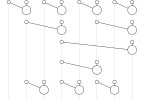

In [49]:
render(prefix!(DummyArray(8), +))

Now we can see that `prefix!` rearranges the operations to form two spanning trees:

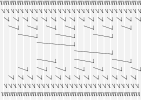

In [50]:
render(prefix!(DummyArray(120),+))

prefix!(DummyArray(8), +) = DummyArray(8, Any[], Any[(Any[1, 2], [2]), (Any[3, 4], [4]), (Any[5, 6], [6]), (Any[7, 8], [8]), (Any[2, 4], [4]), (Any[6, 8], [8]), (Any[4, 8], [8]), (Any[4, 6], [6]), (Any[2, 3], [3]), (Any[4, 5], [5]), (Any[6, 7], [7])])


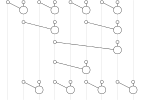

In [51]:
function prefix!(y, +)
    l=length(y)
    k=ceil(Int, log2(l))
    @inbounds for j=1:k, i=2^j:2^j:min(l, 2^k)              #"reduce"
        y[i] = y[i-2^(j-1)] + y[i]
    end
    @inbounds for j=(k-1):-1:1, i=3*2^(j-1):2^j:min(l, 2^k) #"broadcast"
        y[i] = y[i-2^(j-1)] + y[i]
    end
    y
end
@show prefix!(DummyArray(8),+)
render(prefix!(DummyArray(9),+))

In [ ]:
#Look at the compose tree
#render(prefix8!(AccessArray(8),+)) |> introspect

as contrasted with the serial code:

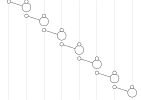

In [52]:
render(prefix_serial!(DummyArray(8),+))

Interact.Options{:SelectionSlider,Any}(53: "input-16" = 90 Any , "npp", 90, "90", 90, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(11, "11"),Pair{Any,Any}(134, "134"),Pair{Any,Any}(158, "158"),Pair{Any,Any}(160, "160"),Pair{Any,Any}(29, "29"),Pair{Any,Any}(131, "131"),Pair{Any,Any}(173, "173"),Pair{Any,Any}(74, "74"),Pair{Any,Any}(176, "176"),Pair{Any,Any}(57, "57")…)), Any[], Any[], true, "horizontal")

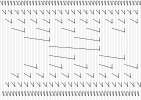

In [53]:
@manipulate for npp=1:180
    render(prefix!(DummyArray(npp),+))
end

Interact.Options{:SelectionSlider,Any}(59: "input-18" = 90 Any , "npp", 90, "90", 90, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(11, "11"),Pair{Any,Any}(134, "134"),Pair{Any,Any}(158, "158"),Pair{Any,Any}(160, "160"),Pair{Any,Any}(29, "29"),Pair{Any,Any}(131, "131"),Pair{Any,Any}(173, "173"),Pair{Any,Any}(74, "74"),Pair{Any,Any}(176, "176"),Pair{Any,Any}(57, "57")…)), Any[], Any[], true, "horizontal")

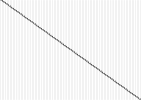

In [55]:
@manipulate for npp=1:180
    render(prefix_serial!(DummyArray(npp),+))
end

In [ ]:
draw(PDF("serial.pdf", 3.5inch, 3.5inch), render(prefix_serial!(AccessArray(8),+)))
draw(PDF("tree.pdf", 3.5inch, 3.5inch), render(prefix8!(AccessArray(8),+)))

# Polymorphism for parallel operations

Now let's run `prefix` in parallel on every core on the CPU. Use `addprocs` to attach additional worker processes.

In [ ]:
import Base: fetch, length, +, *
fetch(t::Vector) = map(fetch, t) #Vectorize fetch

#Define elementary operations on remote data
length(r1::RemoteRef)=length(fetch(r1))
+(r1::RemoteRef,r2::RemoteRef)=@spawnat r2.where fetch(r1)+fetch(r2)
*(r1::RemoteRef,r2::RemoteRef)=@spawnat r2.where fetch(r1)*fetch(r2)

For 8 processes, the serial version requires 7 operations. The parallel version uses 11 operations, but they are grouped into 5 simultaneous chunks of operations. Hence we expect that the parallel version runs in 5/7 the time needed for the naïve serial code.

In [ ]:
#Before timing, force Julia to JIT compile the functions
[f([randn(3,3) for i=1:2], *) for f in (prefix_serial!, prefix!)]

addprocs(max(0, Sys.CPU_CORES-nprocs())) #Add all possible processors

timings=Dict{Int,Tuple{Float64,Float64}}()
for np in 2:nprocs()
    gc_enable(false) #Disable garbage collector for timing purposes
    n=1024#4096#3072
    
    #Create RemoteRefs on np processes
    r=[@spawnat p randn(n,n) for p in procs()[1:np]]
    s=fetch(r) #These are in-memory matrices

    #Repeat timings a couple of times and take smallest
    t_ser = minimum([(tic(); prefix_serial!(s, *); toc()) for i=1:2])
    t_par = minimum([(tic(); @sync prefix!(r, *) ; toc()) for i=1:2])
    timings[np] = (t_ser, t_par)
    gc_enable(true)
end
timings

In [ ]:
#timings = #Data from julia.mit.edu
#Dict(
#     1 => ( 15.585,  15.721),
#     2 => ( 16.325,  15.893),
#     3 => ( 32.079,  31.678),
#     4 => ( 46.037,  33.257),
#     5 => ( 61.947,  51.412),
#     6 => ( 77.247,  50.769), 
#     7 => ( 92.588,  67.796),
#     8 => (108.057,  65.185),
#     9 => (123.556,  68.197),
#    10 => (138.408,  66.658),
#    11 => (153.392,  82.580),
#    12 => (168.874,  83.373),
#    13 => (184.227,  82.875),
#    14 => (199.741,  83.098),
#    15 => (215.881, 101.271),
#    16 => (230.531, 104.860),
#    17 => (246.576, 103.229),
#    18 => (261.412, 102.497),
#    19 => (276.926, 103.367),
#    20 => (294.404, 104.162),
#    21 => (308.995, 104.944),
#    22 => (323.287, 104.838),
#    23 => (340.173, 121.495),
#    24 => (353.717, 119.729),
#    25 => (369.113, 120.281),
#    26 => (384.638, 118.710),
#    27 => (402.484, 119.237),
#    28 => (417.036, 119.980),
#    29 => (431.273, 120.463),
#    30 => (446.288, 120.560),
#    31 => (461.756, 137.209),
#    32 => (476.653, 135.873),
#    33 => (493.989, 138.150),
#    34 => (508.089, 137.998),
#    35 => (523.703, 139.059),
#    36 => (539.305, 135.201),
#    37 => (554.201, 138.242),
#    38 => (569.276, 137.470),
#    39 => (585.268, 137.261),
#    40 => (599.921, 137.871),
#    41 => (615.718, 137.887),
#    42 => (632.463, 137.579),
#    43 => (647.355, 138.181),
#    44 => (664.344, 139.917),
#    45 => (678.899, 138.382),
#    46 => (695.815, 138.354),
#    47 => (717.068, 154.826),
#    48 => (730.902, 155.603),
#    49 => (745.608, 154.549),
#    50 => (756.012, 154.244),
#    51 => (769.611, 154.000),
#    52 => (793.350, 152.893),
#    53 => (801.568, 155.276),
#    54 => (818.174, 153.436),
#    55 => (832.994, 155.923),
#    56 => (849.526, 155.721),
#    57 => (863.337, 155.289),
#    58 => (881.577, 156.188),
#    59 => (893.735, 157.889),
#    60 => (911.597, 155.557),
#    61 => (925.117, 157.048),
#    62 => (940.897, 153.338),
#    63 => (954.825, 173.942),
#    64 => (990.757, 173.236),
#    65 => (987.457, 172.005),
#    66 => (1009.688, 173.869),
#    67 => (1022.357, 173.303),
#    68 => (1043.536, 175.044),
#    69 => (1052.156, 173.361),
#    70 => (1067.174, 172.230),
#    71 => (1079.543, 173.491),
#    72 => (1101.516, 174.311),
#    73 => (1119.993, 174.057),
#    74 => (1136.092, 175.804),
#    75 => (1154.758, 175.075),
#    76 => (1170.732, 173.453),
#    77 => (1184.598, 171.936),
#    78 => (1190.922, 172.809),
#    79 => (1204.645, 172.878),
#)

In [ ]:
speedup(p::Integer) = ((p-1)/(floor(Int, log2(p)) + 1 + floor(Int, log2(p/3))))
#for (np, (t_ser, t_par)) in sort!([x for x in timings])
#    @printf("np: %3d Serial: %.3f sec  Parallel: %.3f sec  speedup: %.3fx (theory=%.3fx)\n",
#        np, t_ser, t_par, t_ser/t_par, speedup(np))
#end

xend = 1+maximum(keys(timings))

theplot=plot(layer(x=2:xend, y=map(speedup, 2:xend), Geom.line(), Theme(default_color=colorant"darkkhaki")),
layer(x=[np+1 for (np, (t_ser, t_par)) in timings],
      y=[t_ser/t_par for (np, (t_ser, t_par)) in timings],
    Geom.point, Theme(default_color=colorant"firebrick",
        default_point_size=1.25pt, highlight_width=0pt)),
    Guide.xlabel("Number of processors, p"), Guide.ylabel("Speedup, r"))

In [ ]:
labeledplot = compose(render(theplot),
compose(context(), stroke(colorant"purple"), #Powers of 2
text(0.21, 0.73, "2"), text(0.24, 0.72, "4"), text(0.27, 0.7, "8"), text(0.33, 0.63, "16"),
text(0.47, 0.53, "32"), text(0.76, 0.35, "64")),
compose(context(), stroke(colorant"green"), #3x powers of 2
text(0.25, 0.62, "6"), text(0.28, 0.57, "12"), text(0.39, 0.49, "24"), text(0.63, 0.32, "48"),
)
)
draw(SVG(3.5inch, 3.2inch), labeledplot)

In [ ]:
draw(SVG("scaling.svg", 3.5inch, 3.2inch), labeledplot)
#draw(PDF("scaling.pdf", 3.5inch, 3inch), theplot)

The exact same serial code now runs in parallel thanks to multiple dispatch!

#Formal verification

Julia allows us to implement very easily the interval of summations monoid technique for verifying the correctness of prefix sums ([doi:10.1145/2535838.2535882](http://dx.doi.org/10.1145/2535838.2535882)).

In [ ]:
#Definition 4.3 of Chong et al., 2014
abstract ⊤
abstract Id
typealias 𝕊 Union(UnitRange, Type{⊤}, Type{Id})

In [ ]:
⊕(I::UnitRange, J::UnitRange) = I.stop+1==J.start ? (I.start:J.stop) : ⊤
⊕(::Type{Id}, ::Type{Id}) = Id
⊕(I::𝕊, ::Type{Id}) = I
⊕(::Type{Id}, I::𝕊) = I
⊕(I::𝕊, J::𝕊) = ⊤

In [ ]:
for kernel in (prefix_serial!, prefix!), n=1:1000
    @assert kernel([k:k for k=1:n], ⊕) == [1:k for k=1:n]
end

Wrong kernels produce type errors!

In [ ]:
function prefix_wrong!(y, .+)
    l = length(y)
    offset = 1
    z = copy(y)
    while offset < l
        for i=offset+1:l
            z[i] = y[i-offset] .+ z[i]
        end
        offset += 2
        y = copy(z)
    end
    y
end

@assert prefix_wrong!([k:k for k=1:8], ⊕) #Should produce conversion error

In [ ]:
@manipulate for npp=1:10
    render(prefix_wrong!(AccessArray(npp),+))
end

# Experimental code which doesn't work

In this section I play with other parallel prefix algorithms. All the ones here suffer from read antidependencies and they break the logic I used to draw the gates.

In [ ]:
#Kogge-Stone variant
#Works but doesn't render properly
function prefix_ks!(y, .+)
    l = length(y)
    offset = 1
    z = copy(y)
    while offset < l
        for i=offset+1:l
            z[i] = y[i-offset] .+ z[i]
        end
        offset *= 2
        y = copy(z)
    end
    y
end

@assert prefix_ks!(ones(8), +) == [1:8;]

In [ ]:
Base.copy(A::AccessArray) = A

render(prefix_ks!(AccessArray(8),+))

In [ ]:
#Hillis-Steele = Kogge-Stone
function prefix_hs!(y, +)
    l = length(y)
    lk = floor(Int, log2(l))
    for d=1:lk
        for k=2d:l
            y[k] = y[k-2^(d-1)] + y[k]
        end
    end
    y
end
prefix_hs!(ones(4), +)

In [ ]:
render(prefix_hs!(AccessArray(4), +))

In [ ]:
#Sklansky
function prefix_s!(y, +)
    n = length(y)
    for d=1:log2(n)
        for k=1:n÷2+1
            block = 2 * (k - (mod(k, 2^d)))
            me = block + mod(k, 2^d) + 2^d
            spine = block + 2^d - 1
            if spine ≤ n && me ≤ n
                y[me] = y[me] + y[spine]
            end
        end
    end
    y
end
prefix_s!(ones(4), +)

In [ ]:
function prefix(v,⊕)
    @show v
    k=length(v)
    k≤1 && return v
    v[2:2:k] = @show v[1:2:k-1]⊕v[2:2:k]  # Line 1
    v[2:2:k] = @show prefix(v[2:2:k],⊕)   # Line 2
    v[3:2:k] = @show v[2:2:k-1]⊕v[3:2:k]  # Line 3
    v
end

In [ ]:
prefix(ones(8),+)

In [ ]:
function ⊕{T<:Range}(v1::Vector{T}, v2::Vector{T})
    for v in (v1, v2), i in 1:length(v)-1
        @assert v[i].stop + 1 == v[i+1].start
    end
    if length(v1)>0 && length(v2)>0
        @assert v1[end].stop + 1 == v2[1].start
        v1[1].start:v2[end].stop
    elseif length(v1)>0 #&& length(v2)==0
        v1[1].start:v1[end].stop
    elseif length(v2)>0 #&& length(v1)==0
        v2[1].start:v2[end].stop
    else #Both are empty
        v1
    end
end

In [ ]:
for kernel in (prefix,), n=1:100#(prefix_serial!, prefix!, prefix_ks!), n=1:100
    @assert kernel([k:k for k=1:n], ⊕) == [1:k for k=1:n]
end